## Gradient Boosting

In [1]:
# Import necessary libraries for Gradient Boosting implementation
import numpy as np
from sklearn.tree import DecisionTreeRegressor  # Weak learner for regression
from sklearn.tree import DecisionTreeClassifier  # Weak learner for classification
from sklearn.base import clone  # Used to create copies of the base learner
import matplotlib.pylab as plt 
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import os
import dataframe_image as dfi

### Mass Shootings

,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Target
1128,4,0,0,1,0
4531,5,0,0,0,0
1702,3,0,0,0,1
4198,3,0,0,0,1
2226,3,0,1,1,1
4459,5,0,0,0,0
3716,5,0,0,0,0
1115,2,0,0,1,1
4727,6,0,0,0,0
257,6,0,0,1,0


,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Target
4678,4,0,0,0,1
1432,3,0,0,0,1
410,4,0,1,0,0
3869,2,0,0,0,1
5068,7,0,0,0,0
2458,3,0,0,0,1
2822,5,0,0,0,0
3566,0,1,0,0,1
3404,4,0,0,1,0
2836,4,0,0,1,0


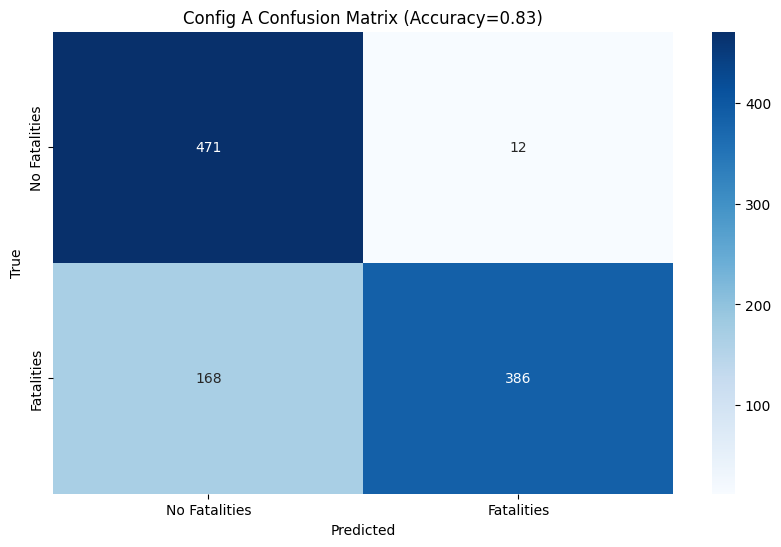

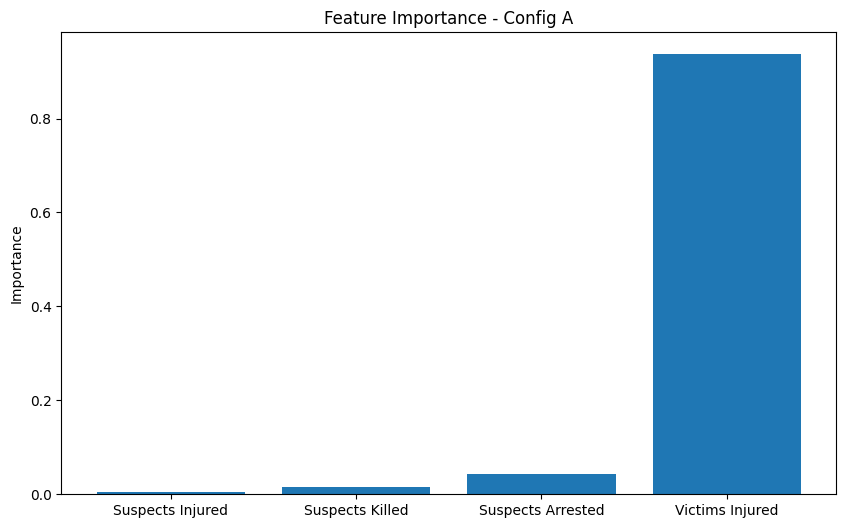

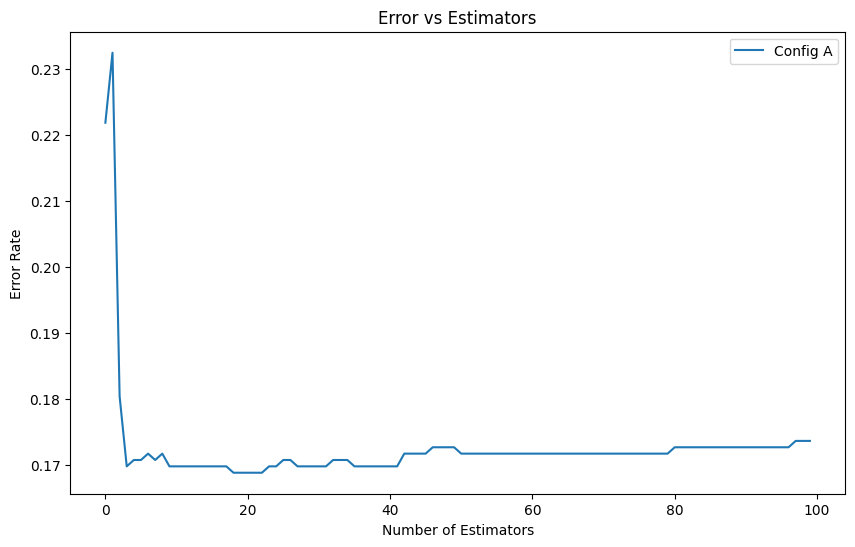

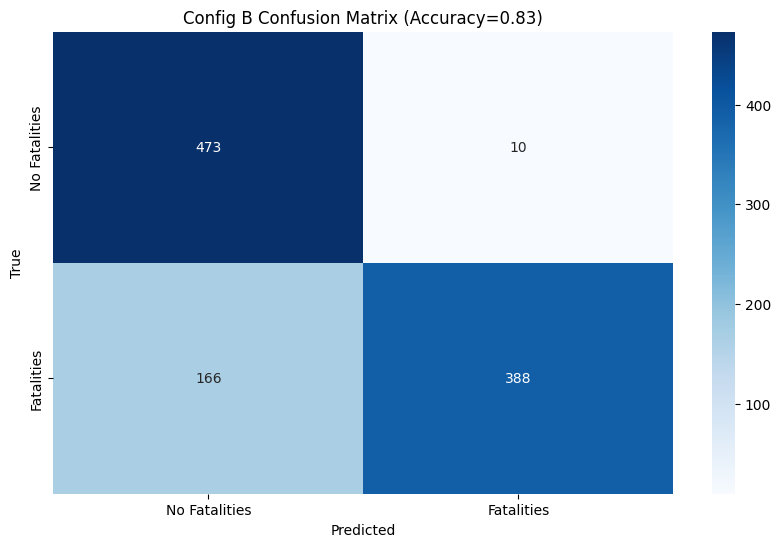

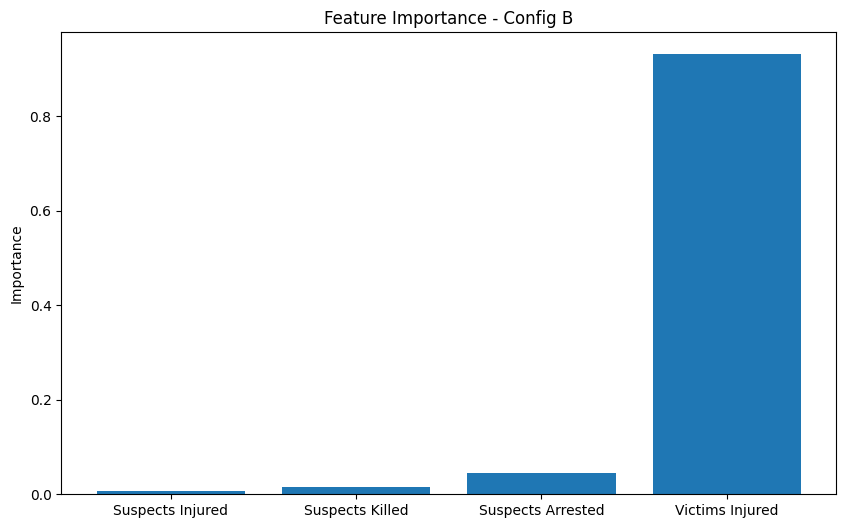

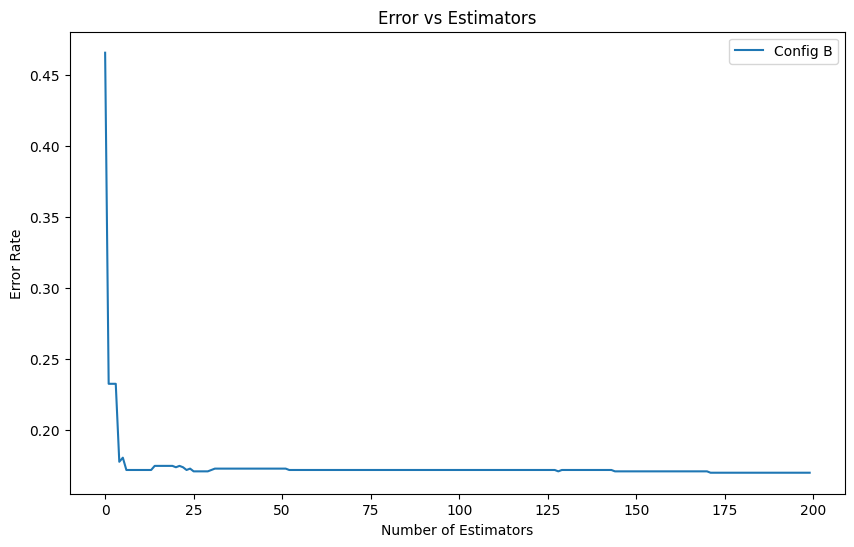

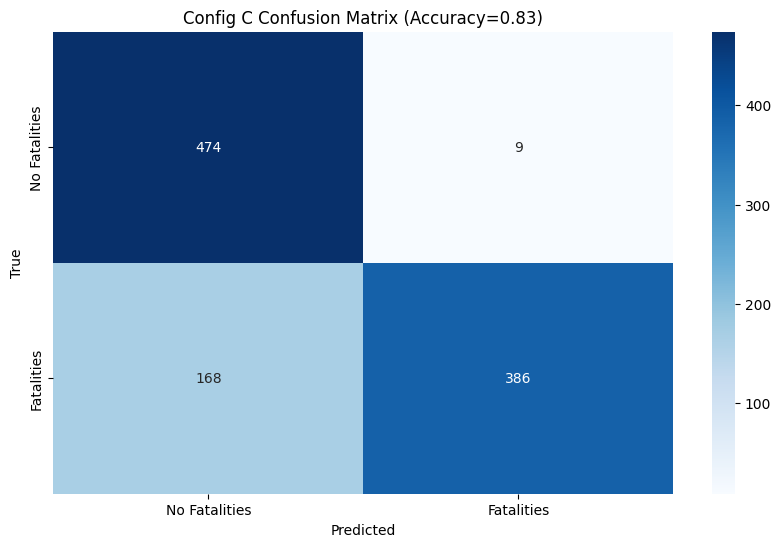

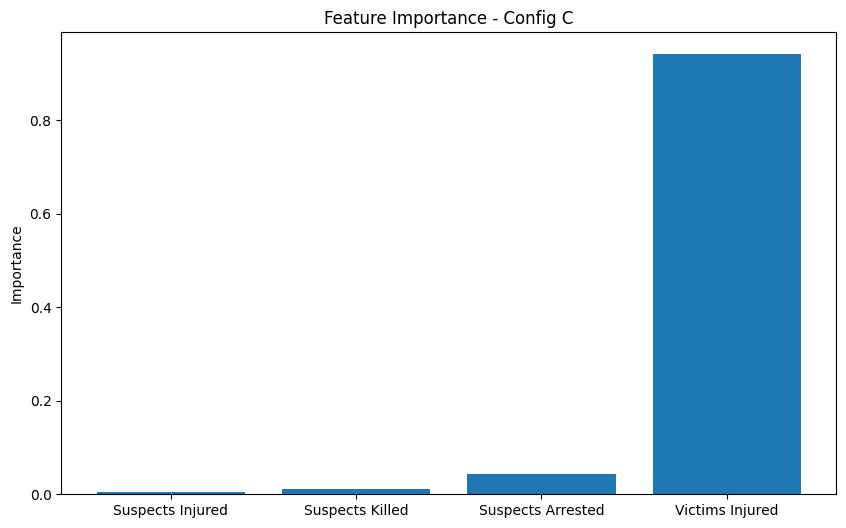

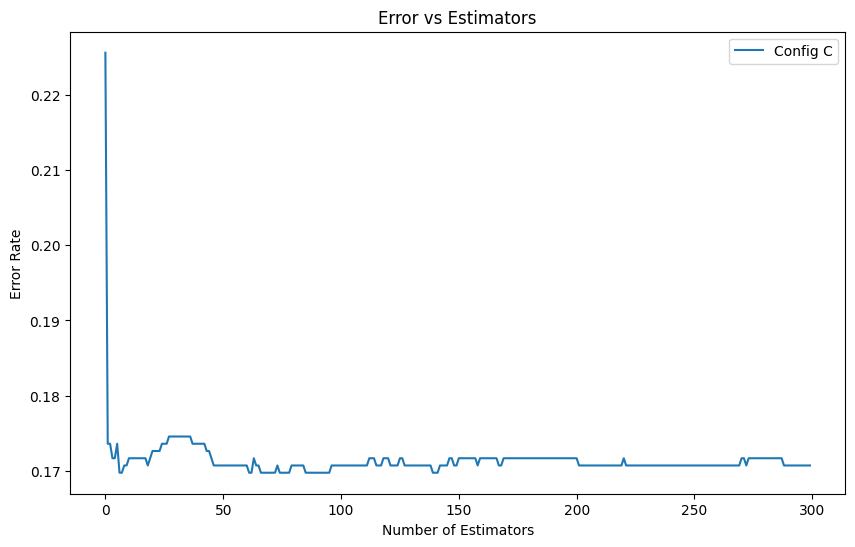

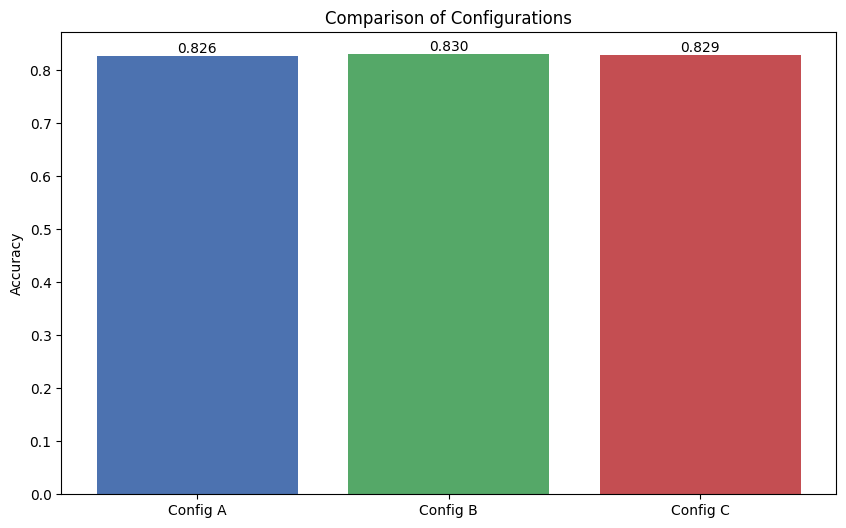

Config A: Accuracy = 0.826
Config B: Accuracy = 0.830
Config C: Accuracy = 0.829
Best performing configuration: Config B with Accuracy = 0.830


In [2]:
# --- Load and prepare your dataset ---
df = pd.read_csv("gunviolencearchive_mass_shooting_all_years.csv")
df = df.fillna(0)

# Binary target: 1 if fatalities occurred, else 0
df["Target"] = (df["Victims Killed"] > 0).astype(int)

features = ["Victims Injured", "Suspects Killed", "Suspects Injured", "Suspects Arrested"]
X = df[features]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# combine X_train and y_train for better visualization
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=["Target"])], axis=1)
display(train_df.head(10))
os.makedirs('../../recourses/img/tables', exist_ok=True)
dfi.export(train_df.head(10), '../recourses/img/tables/boosting_train_mass.png', table_conversion='chrome')

# combine X_test and y_test for better visualization
test_df = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test, columns=["Target"])], axis=1)
display(test_df.head(10))
os.makedirs('../../recourses/img/tables', exist_ok=True)
dfi.export(test_df.head(10), '../recourses/img/tables/boosting_test_mass.png', table_conversion='chrome')

# --- Configurations to test ---
configs = {
    "Config A": {"learning_rate":0.1, "n_estimators":100, "max_depth":3},
    "Config B": {"learning_rate":0.05, "n_estimators":200, "max_depth":4},
    "Config C": {"learning_rate":0.2, "n_estimators":300, "max_depth":2},
}

results = {}

# --- Evaluation function ---
def evaluate_model(config_name, params):
    model = GradientBoostingClassifier(
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Confusion matrix plot
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fatalities","Fatalities"],
                yticklabels=["No Fatalities","Fatalities"])
    plt.title(f"{config_name} Confusion Matrix (Accuracy={acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("../recourses/img/plots/boosting_mass_cm.png")
    plt.show()

    # Feature importance plot
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(10,6))
    plt.bar(range(len(sorted_idx)), importance[sorted_idx], align="center")
    plt.xticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
    plt.ylabel("Importance")
    plt.title(f"Feature Importance - {config_name}")
    plt.savefig("../recourses/img/plots/boosting_mass_fi.png")
    plt.show()
    
    # Error vs estimators plot
    test_errors = [
        1 - accuracy_score(y_test, y_pred_stage)
        for y_pred_stage in model.staged_predict(X_test)
    ]
    plt.figure(figsize=(10,6))
    plt.plot(test_errors, label=config_name)
    plt.xlabel("Number of Estimators")
    plt.ylabel("Error Rate")
    plt.title("Error vs Estimators")
    plt.legend()
    plt.savefig("../recourses/img/plots/boosting_mass_error.png")
    plt.show()

    results[config_name] = acc

# --- Run all configs ---
for name, params in configs.items():
    evaluate_model(name, params)

# --- Compare accuracies across configs ---
plt.figure(figsize=(10,6))
bars = plt.bar(results.keys(), results.values(), color=["#4c72b0","#55a868","#c44e52"])
plt.ylabel("Accuracy")
plt.title("Comparison of Configurations")
# Add accuracy labels on top of each bar
for bar, acc in zip(bars, results.values()):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        height,                            # y position (top of bar)
        f"{acc:.3f}",                      # text (formatted accuracy)
        ha="center", va="bottom"           # align center horizontally, just above bar
    )
plt.savefig("../recourses/img/plots/boosting_mass_comparison.png")
plt.show()

# --- Print summary ---
for name, acc in results.items():
    print(f"{name}: Accuracy = {acc:.3f}")

best_config = max(results, key=results.get)
print(f"Best performing configuration: {best_config} with Accuracy = {results[best_config]:.3f}")


### School Shootings

,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Target
4355,0,0,0,0,0
5729,0,0,0,2,0
5669,0,0,0,0,0
1554,0,0,0,1,0
8018,0,0,0,1,0
5743,0,0,0,1,0
2963,0,0,0,1,0
3027,0,0,0,1,0
2542,0,0,0,1,0
833,0,0,0,0,0


,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Target
2908,0,0,0,1,0
2728,0,0,0,0,0
2260,2,0,0,0,0
5957,0,0,0,1,0
8103,1,0,0,0,0
6299,0,0,0,1,0
2456,0,0,0,0,0
3484,0,0,0,1,0
3378,0,0,0,0,0
1055,0,0,0,1,0


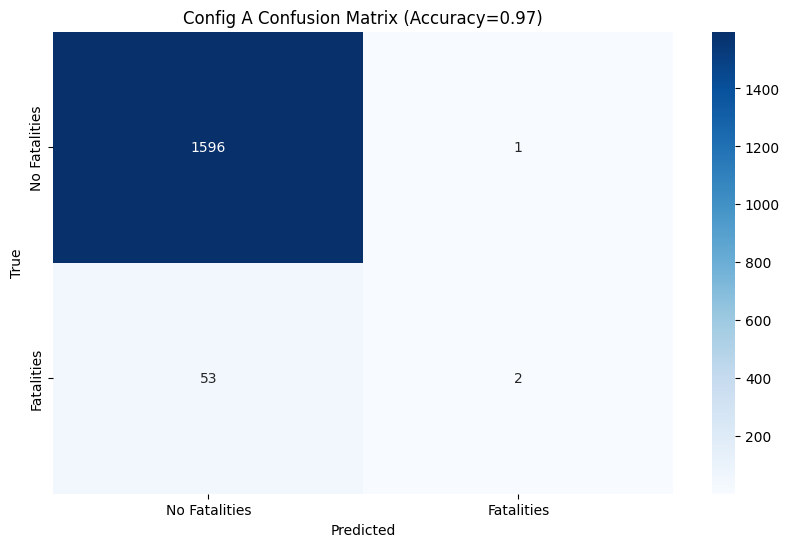

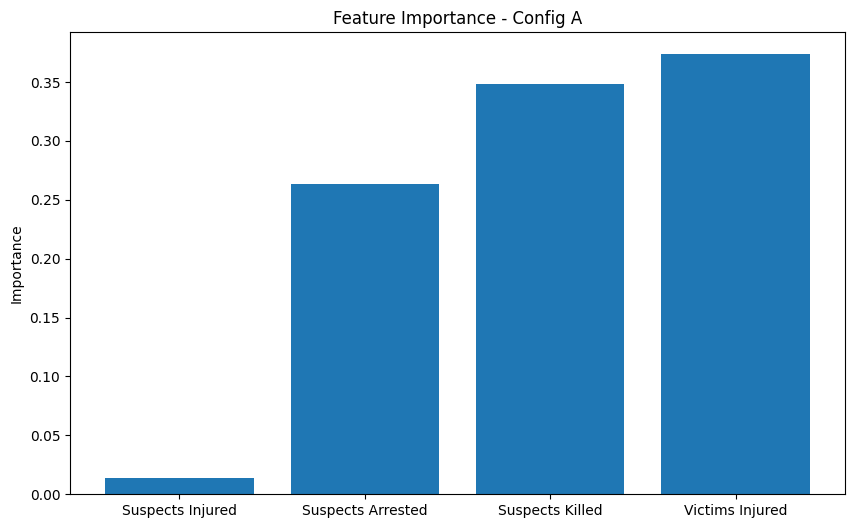

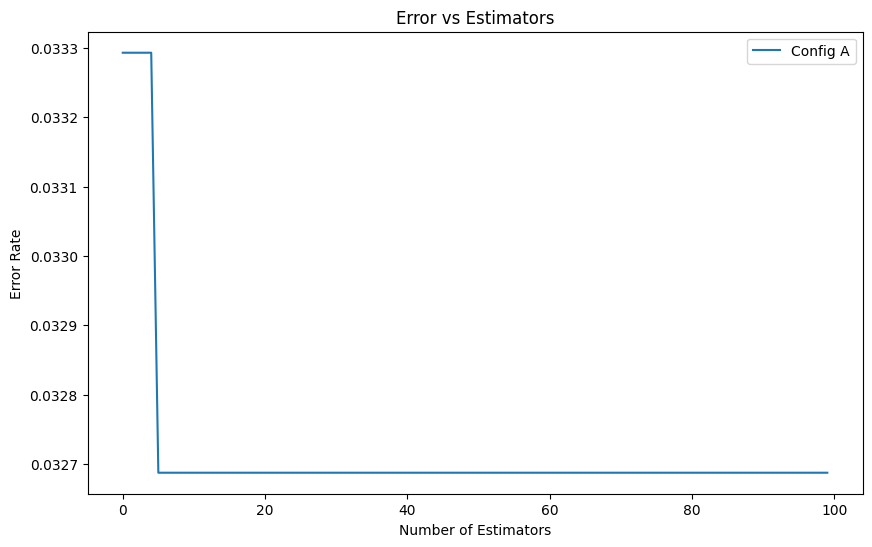

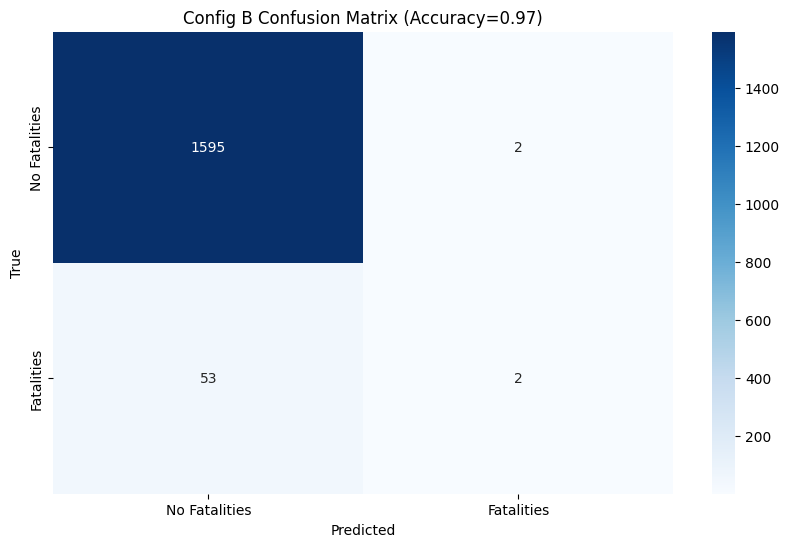

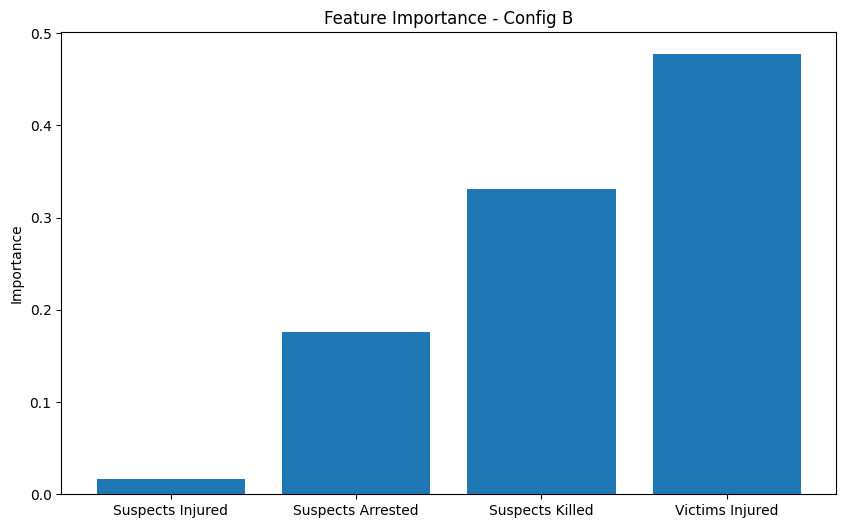

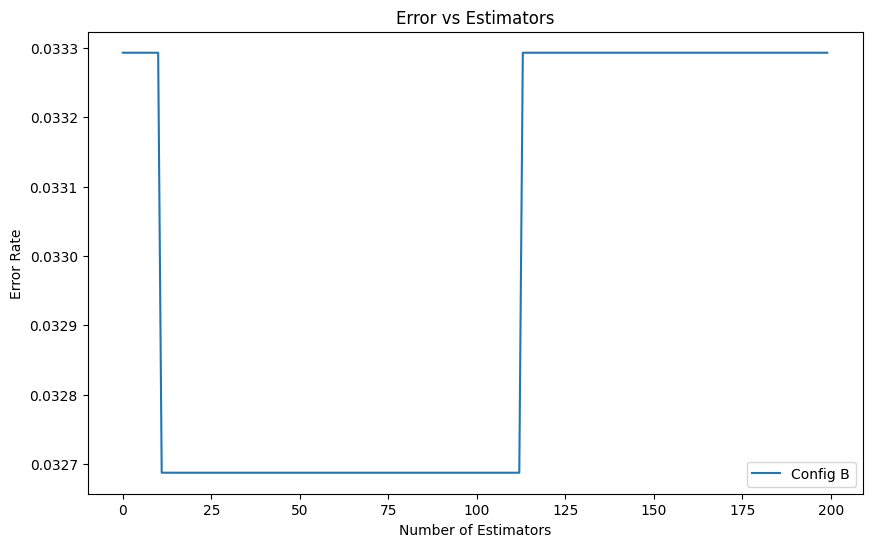

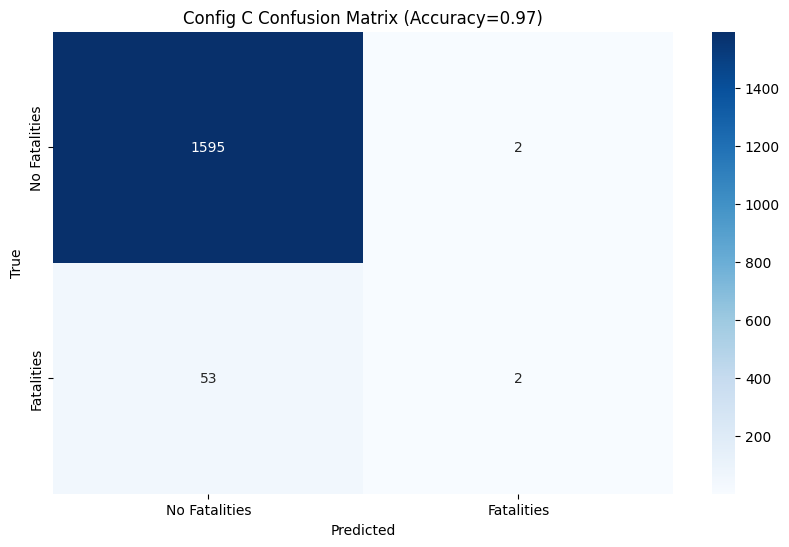

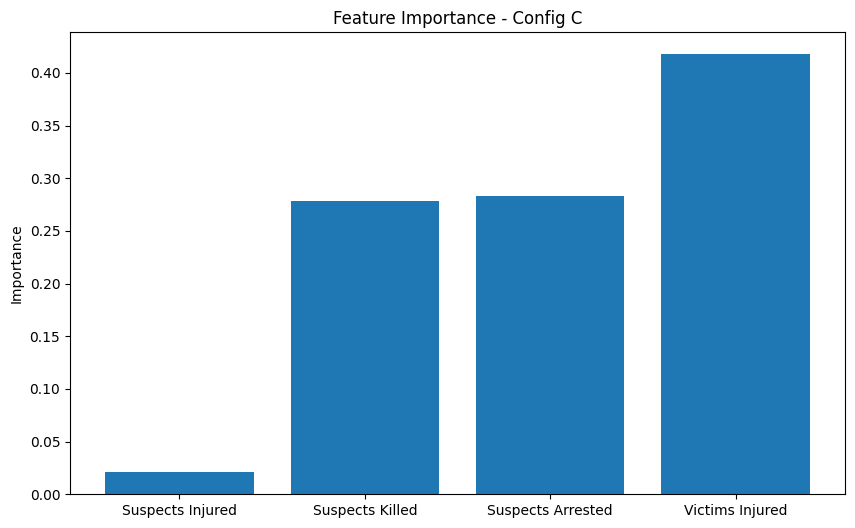

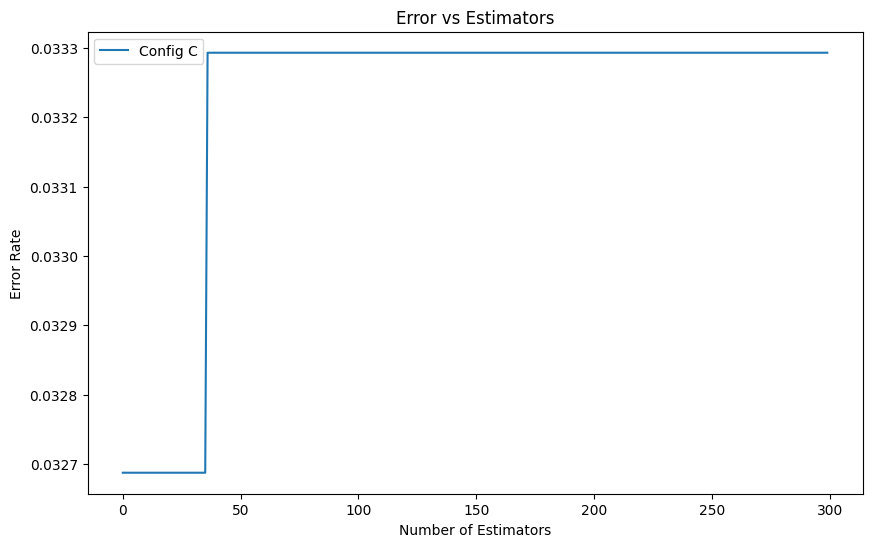

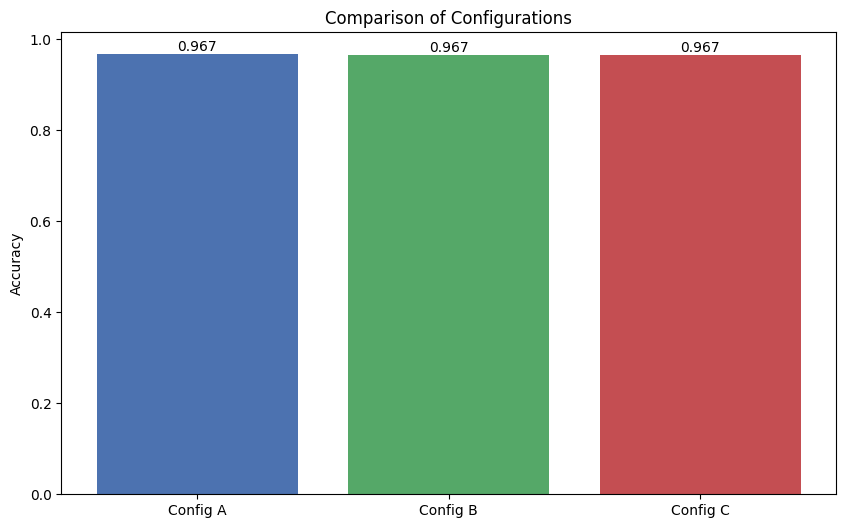

Config A: Accuracy = 0.967
Config B: Accuracy = 0.967
Config C: Accuracy = 0.967
Best performing configuration: Config A with Accuracy = 0.967


In [3]:
# --- Load and prepare your dataset ---
df = pd.read_csv("gunviolencearchive_school_shooting.csv")
df = df.fillna(0)

# Binary target: 1 if fatalities occurred, else 0
df["Target"] = (df["Victims Killed"] > 0).astype(int)

features = ["Victims Injured", "Suspects Killed", "Suspects Injured", "Suspects Arrested"]
X = df[features]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# combine X_train and y_train for better visualization
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=["Target"])], axis=1)
display(train_df.head(10))
os.makedirs('../../recourses/img/tables', exist_ok=True)
dfi.export(train_df.head(10), '../recourses/img/tables/boosting_train_school.png', table_conversion='chrome')

# combine X_test and y_test for better visualization
test_df = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test, columns=["Target"])], axis=1)
display(test_df.head(10))
os.makedirs('../../recourses/img/tables', exist_ok=True)
dfi.export(test_df.head(10), '../recourses/img/tables/boosting_test_school.png', table_conversion='chrome')

# --- Configurations to test ---
configs = {
    "Config A": {"learning_rate":0.1, "n_estimators":100, "max_depth":3},
    "Config B": {"learning_rate":0.05, "n_estimators":200, "max_depth":4},
    "Config C": {"learning_rate":0.2, "n_estimators":300, "max_depth":2},
}

results = {}

# --- Evaluation function ---
def evaluate_model(config_name, params):
    model = GradientBoostingClassifier(
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Confusion matrix plot
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fatalities","Fatalities"],
                yticklabels=["No Fatalities","Fatalities"])
    plt.title(f"{config_name} Confusion Matrix (Accuracy={acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("../recourses/img/plots/boosting_school_cm.png")
    plt.show()

    # Feature importance plot
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(10,6))
    plt.bar(range(len(sorted_idx)), importance[sorted_idx], align="center")
    plt.xticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
    plt.ylabel("Importance")
    plt.title(f"Feature Importance - {config_name}")
    plt.savefig("../recourses/img/plots/boosting_school_fi.png")
    plt.show()

    # Error vs estimators plot
    test_errors = [
        1 - accuracy_score(y_test, y_pred_stage)
        for y_pred_stage in model.staged_predict(X_test)
    ]
    plt.figure(figsize=(10,6))
    plt.plot(test_errors, label=config_name)
    plt.xlabel("Number of Estimators")
    plt.ylabel("Error Rate")
    plt.title("Error vs Estimators")
    plt.legend()
    plt.savefig("../recourses/img/plots/boosting_school_error.png")
    plt.show()

    results[config_name] = acc

# --- Run all configs ---
for name, params in configs.items():
    evaluate_model(name, params)

# --- Compare accuracies across configs ---
plt.figure(figsize=(10,6))
bars = plt.bar(results.keys(), results.values(), color=["#4c72b0","#55a868","#c44e52"])
plt.ylabel("Accuracy")
plt.title("Comparison of Configurations")
# Add accuracy labels on top of each bar
for bar, acc in zip(bars, results.values()):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        height,                            # y position (top of bar)
        f"{acc:.3f}",                      # text (formatted accuracy)
        ha="center", va="bottom"           # align center horizontally, just above bar
    )
plt.savefig("../recourses/img/plots/boosting_school_comparison.png")
plt.show()

# --- Print summary ---
for name, acc in results.items():
    print(f"{name}: Accuracy = {acc:.3f}")

best_config = max(results, key=results.get)
print(f"Best performing configuration: {best_config} with Accuracy = {results[best_config]:.3f}")


### Police Involed Shootings

,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Target
2257,1,0,0,0,0
2770,1,0,0,1,0
2354,1,0,0,1,0
1803,1,0,1,0,0
1251,2,0,0,1,0
1364,1,0,0,0,0
2815,1,1,0,0,0
1073,1,1,1,0,0
1839,1,0,1,1,0
1564,1,1,0,0,0


,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Target
2008,1,0,0,0,0
1041,2,0,1,1,1
2358,1,0,0,2,0
2164,1,0,0,1,1
1641,2,0,0,1,0
196,1,0,0,1,0
2382,1,1,0,0,0
450,1,0,0,0,0
2472,1,0,1,0,0
2429,3,1,0,0,1


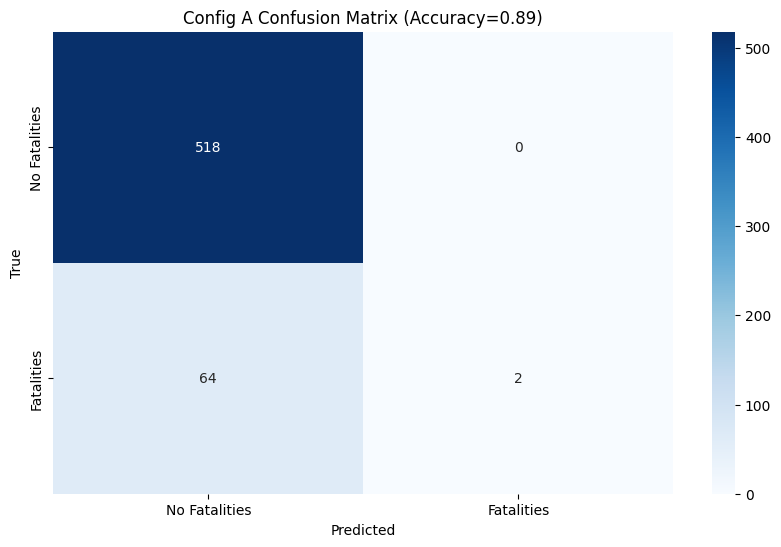

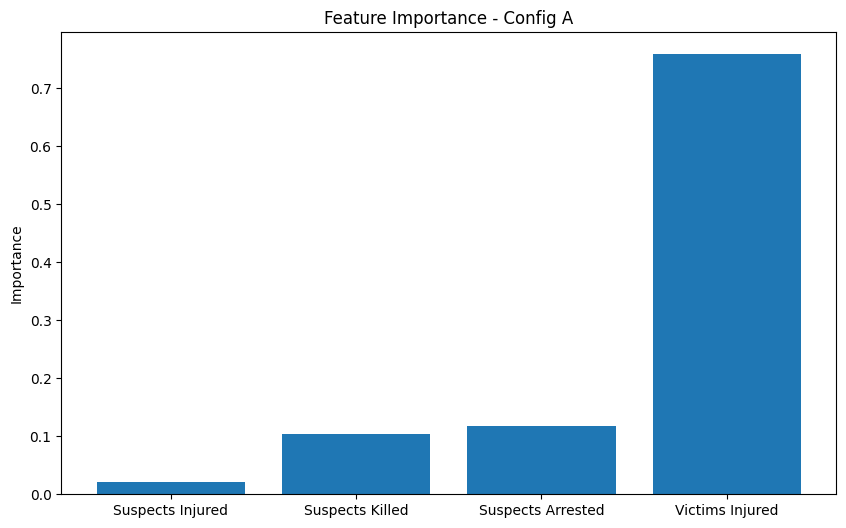

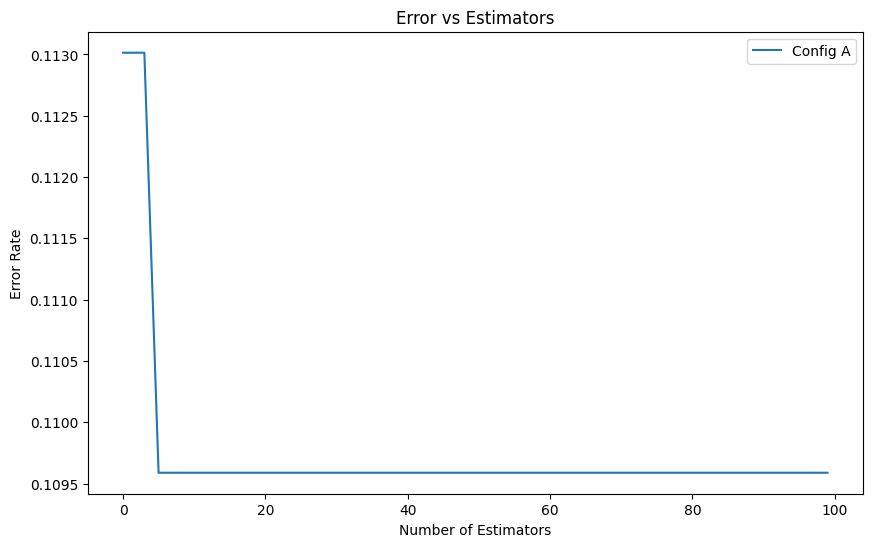

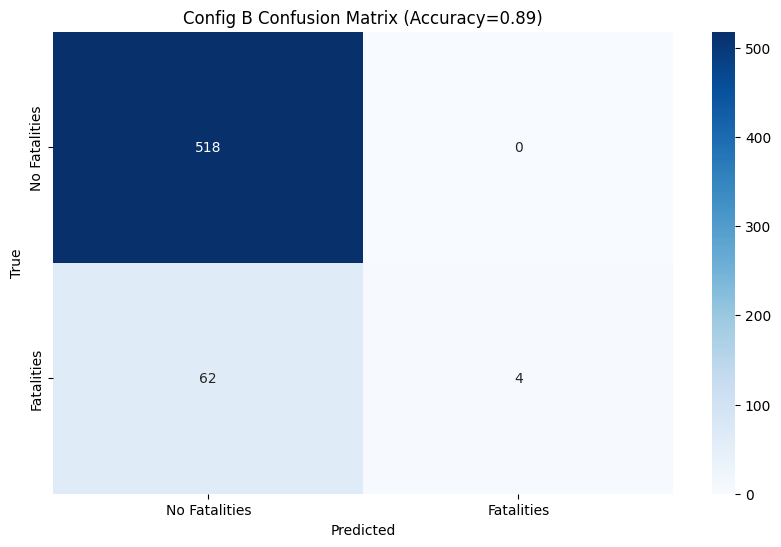

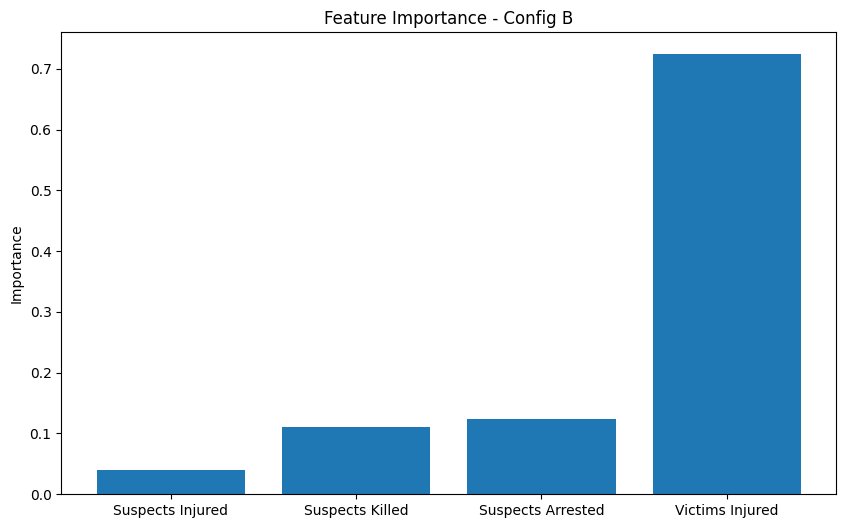

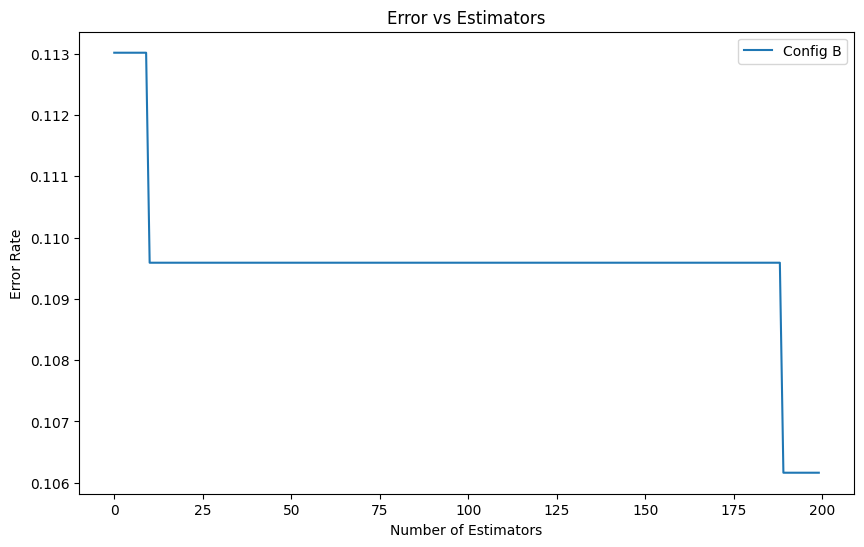

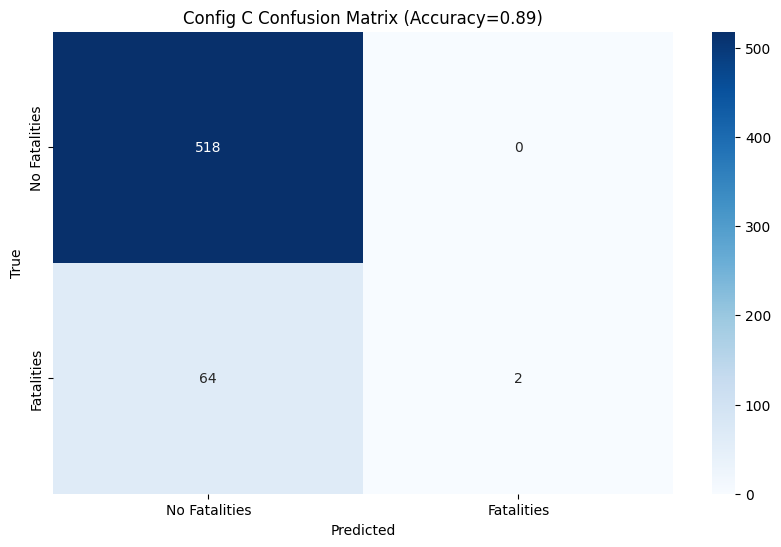

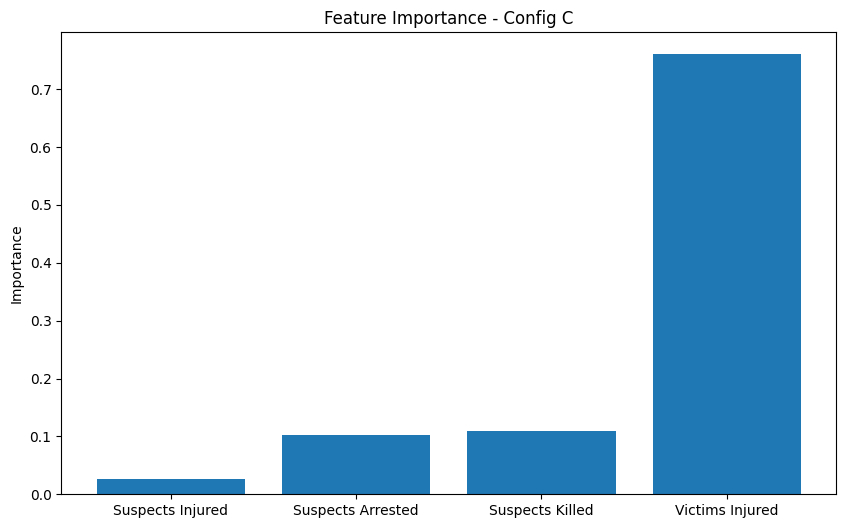

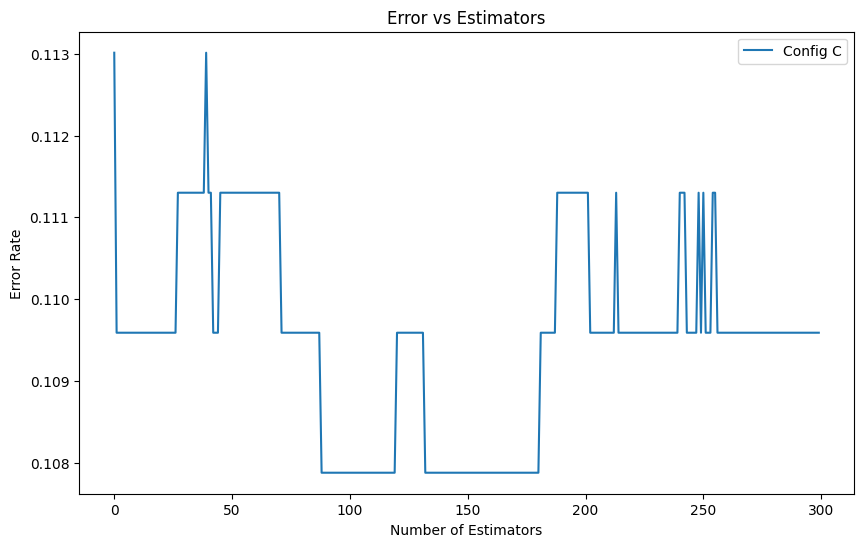

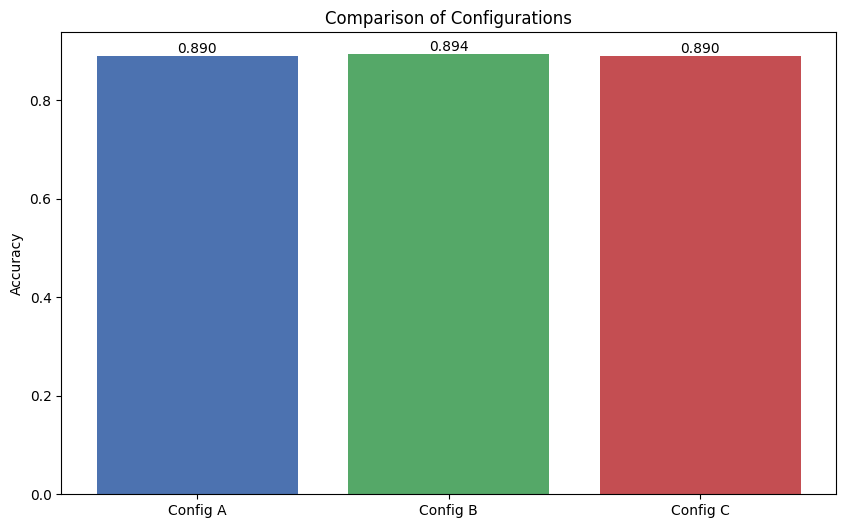

Config A: Accuracy = 0.890
Config B: Accuracy = 0.894
Config C: Accuracy = 0.890
Best performing configuration: Config B with Accuracy = 0.894


In [4]:
# --- Load and prepare your dataset ---
df = pd.read_csv("gunviolencearchive_officer_involved_shooting.csv")
df = df.fillna(0)

# Binary target: 1 if fatalities occurred, else 0
df["Target"] = (df["Victims Killed"] > 0).astype(int)

features = ["Victims Injured", "Suspects Killed", "Suspects Injured", "Suspects Arrested"]
X = df[features]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# combine X_train and y_train for better visualization
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=["Target"])], axis=1)
display(train_df.head(10))
os.makedirs('../../recourses/img/tables', exist_ok=True)
dfi.export(train_df.head(10), '../recourses/img/tables/boosting_train_officer.png', table_conversion='chrome')

# combine X_test and y_test for better visualization
test_df = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test, columns=["Target"])], axis=1)
display(test_df.head(10))
os.makedirs('../../recourses/img/tables', exist_ok=True)
dfi.export(test_df.head(10), '../recourses/img/tables/boosting_test_officer.png', table_conversion='chrome')

# --- Configurations to test ---
configs = {
    "Config A": {"learning_rate":0.1, "n_estimators":100, "max_depth":3},
    "Config B": {"learning_rate":0.05, "n_estimators":200, "max_depth":4},
    "Config C": {"learning_rate":0.2, "n_estimators":300, "max_depth":2},
}

results = {}

# --- Evaluation function ---
def evaluate_model(config_name, params):
    model = GradientBoostingClassifier(
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Confusion matrix plot
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fatalities","Fatalities"],
                yticklabels=["No Fatalities","Fatalities"])
    plt.title(f"{config_name} Confusion Matrix (Accuracy={acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("../recourses/img/plots/boosting_officer_cm.png")
    plt.show()

    # Feature importance plot
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    plt.figure(figsize=(10,6))
    plt.bar(range(len(sorted_idx)), importance[sorted_idx], align="center")
    plt.xticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
    plt.ylabel("Importance")
    plt.title(f"Feature Importance - {config_name}")
    plt.savefig("../recourses/img/plots/boosting_officer_fi.png")
    plt.show()

    # Error vs estimators plot
    test_errors = [
        1 - accuracy_score(y_test, y_pred_stage)
        for y_pred_stage in model.staged_predict(X_test)
    ]
    plt.figure(figsize=(10,6))
    plt.plot(test_errors, label=config_name)
    plt.xlabel("Number of Estimators")
    plt.ylabel("Error Rate")
    plt.title("Error vs Estimators")
    plt.legend()
    plt.savefig("../recourses/img/plots/boosting_officer_error.png")
    plt.show()

    results[config_name] = acc

# --- Run all configs ---
for name, params in configs.items():
    evaluate_model(name, params)

# --- Compare accuracies across configs ---
plt.figure(figsize=(10,6))
bars = plt.bar(results.keys(), results.values(), color=["#4c72b0","#55a868","#c44e52"])
plt.ylabel("Accuracy")
plt.title("Comparison of Configurations")
# Add accuracy labels on top of each bar
for bar, acc in zip(bars, results.values()):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        height,                            # y position (top of bar)
        f"{acc:.3f}",                      # text (formatted accuracy)
        ha="center", va="bottom"           # align center horizontally, just above bar
    )
plt.savefig("../recourses/img/plots/boosting_officer_comparison.png")
plt.show()

# --- Print summary ---
for name, acc in results.items():
    print(f"{name}: Accuracy = {acc:.3f}")

best_config = max(results, key=results.get)
print(f"Best performing configuration: {best_config} with Accuracy = {results[best_config]:.3f}")
